<a href="https://colab.research.google.com/github/asj07/DB/blob/main/Cooking%20market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier


In [ ]:
from google.colab import files

uploaded = files.upload()   # choose your TradingView export (e.g. in.csv)
file_name = list(uploaded.keys())[0]
print("Using file:", file_name)


Saving NIFTY_15m_FEATURES_COLAB.csv to NIFTY_15m_FEATURES_COLAB (5).csv
Using file: NIFTY_15m_FEATURES_COLAB (5).csv


In [ ]:
import io
import zipfile
import pandas as pd

# Get the content of the uploaded file
file_content = uploaded[file_name]

df_raw = None

# Try to read directly first
try:
    df_raw = pd.read_csv(io.BytesIO(file_content), encoding='latin1', sep=',')
except (UnicodeDecodeError, pd.errors.ParserError):
    # If direct read fails, check if it's a zip file
    if file_content.startswith(b'PK'): # Check for ZIP magic number
        try:
            with zipfile.ZipFile(io.BytesIO(file_content), 'r') as zf:
                csv_files = [f for f in zf.namelist() if f.endswith('.csv')]
                if not csv_files:
                    raise ValueError("No CSV file found inside the zip archive.")

                # Take the first CSV file found in the zip
                with zf.open(csv_files[0]) as f:
                    df_raw = pd.read_csv(f, encoding='latin1', sep=',')
        except Exception as zip_e:
            raise type(zip_e)(f"Failed to process zipped file: {zip_e}") from zip_e
    else:
        # If not a zip and direct read failed, try more robust CSV parsing
        parse_attempts = [
            {'encoding': 'latin1', 'sep': ','},
            {'encoding': 'latin1', 'sep': ';'},
            {'encoding': 'utf-8', 'sep': ','},
            {'encoding': 'utf-8', 'sep': ';'},
        ]
        for attempt in parse_attempts:
            try:
                df_raw = pd.read_csv(io.BytesIO(file_content), **attempt)
                break # Success, break out of loop
            except (UnicodeDecodeError, pd.errors.ParserError):
                continue # Try next attempt

        if df_raw is None:
            raise ValueError("Failed to read CSV with various attempts after initial failure.")


print(df_raw.head())
print(df_raw.shape)

              Datetime      Open      High       Low     Close      Volume  \
0  2024-11-04 14:45:00  23972.75  23991.30  23953.40  23953.40  13020000.0   
1  2024-11-04 15:00:00  23997.10  24008.85  23973.60  23973.60  20570000.0   
2  2024-11-04 15:15:00  23990.95  24011.45  23980.80  23997.25  22900000.0   
3  2024-11-05 09:15:00  23983.40  24026.25  23908.65  23943.50  24940000.0   
4  2024-11-05 09:30:00  23958.45  24012.15  23949.50  23983.70  14800000.0   

     return     hv_20  vol_regime  trend_strength  trend_slope   range  \
0  0.000691  0.001397         1.0           33.30        3.330   37.90   
1  0.000843  0.001418         1.0           89.20        8.920   35.25   
2  0.000986  0.001166         1.0          111.30       11.130   30.65   
3 -0.002242  0.001224         1.0           86.75        8.675  117.60   
4  0.001678  0.001272         1.0           78.10        7.810   62.65   

   compression  expansion    settlement  settlement_gap  future_close  target  
0     

In [ ]:
# Take only the first 7 columns (TradingView style export)
use_cols = df_raw.columns[:7]
df = df_raw[use_cols].copy()
print("Using columns:", use_cols)

# Rename them into standard names
df.columns = ["DateTimeRaw","Close","High","Low","Open","Change","Volume"]

# Split date & time from combined text (e.g., "Nov 26, 2025, 09:15")
df["DateTimeRaw"] = df["DateTimeRaw"].astype(str)
df["Date"] = df["DateTimeRaw"].apply(lambda x: " ".join(x.split()[:4]))
df["Time"] = df["DateTimeRaw"].apply(lambda x: x.split()[-1])

# Clean OHLC (remove commas; convert to float)
for col in ["Open","High","Low","Close"]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",","",regex=False)
        .replace("null", np.nan)
        .astype(float)
    )

# Clean Volume like "6.84 M", "124.5 K", "123,456"
def parse_vol(v):
    v = str(v).strip()
    if v in ["", "nan", "null", "-"]:
        return 0.0
    v = v.replace(" ", "")
    if "M" in v:
        return float(v.replace("M","")) * 1_000_000
    if "K" in v:
        return float(v.replace("K","")) * 1_000
    return float(v.replace(",",""))

df["Volume"] = df["Volume"].apply(parse_vol)

# Build proper datetime (dayfirst because TradingView often uses "26 Nov 2025")
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce", dayfirst=True)

final = (
    df[["Datetime","Open","High","Low","Close","Volume"]]
    .dropna()
    .sort_values("Datetime")
    .reset_index(drop=True)
)

print("Cleaned OHLCV shape:", final.shape)
final.head()


Using columns: Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'return'], dtype='object')


/tmp/ipython-input-574233433.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce", dayfirst=True)


Cleaned OHLCV shape: (5316, 6)


,Datetime,Open,High,Low,Close,Volume
0,2024-02-12 09:15:00,24154.65,24154.65,24008.65,24034.60,0.001133
1,2024-02-12 09:30:00,24033.05,24129.40,24030.95,24120.55,-0.005047
2,2024-02-12 09:45:00,24119.60,24147.30,24107.05,24136.10,0.003595
3,2024-02-12 10:00:00,24134.90,24141.25,24079.75,24118.35,0.000634
4,2024-02-12 10:15:00,24117.70,24182.60,24117.70,24164.10,-0.000713


In [ ]:
df_feat = final.copy()

# 1) Log returns
df_feat["return"] = np.log(df_feat["Close"] / df_feat["Close"].shift(1))

# 2) Historical volatility (20-period)
lookback_hv = 20
df_feat["hv_20"] = df_feat["return"].rolling(lookback_hv).std()

# 3) Volatility regime (0 low, 1 mid, 2 high)
low_q = df_feat["hv_20"].quantile(0.33)
high_q = df_feat["hv_20"].quantile(0.66)

def vol_regime(x):
    if pd.isna(x): return np.nan
    if x < low_q: return 0
    elif x < high_q: return 1
    else: return 2

df_feat["vol_regime"] = df_feat["hv_20"].apply(vol_regime)

# 4) Trend strength & slope (10-bar)
trend_len = 10
df_feat["trend_strength"] = df_feat["Close"] - df_feat["Close"].shift(trend_len)
df_feat["trend_slope"] = df_feat["trend_strength"] / trend_len

# 5) Range
df_feat["range"] = df_feat["High"] - df_feat["Low"]
range_ma = df_feat["range"].rolling(lookback_hv).mean()

# 6) Compression / expansion flags
df_feat["compression"] = ((df_feat["hv_20"] < low_q) & (df_feat["range"] < range_ma)).astype(int)
df_feat["expansion"] = ((df_feat["hv_20"] > high_q) & (df_feat["range"] > range_ma)).astype(int)

# 7) Settlement proxy & gap
df_feat["settlement"] = (df_feat["High"] + df_feat["Low"] + df_feat["Close"]) / 3.0
df_feat["settlement_gap"] = df_feat["Close"] - df_feat["settlement"]

# 8) Target: next-candle direction
df_feat["future_close"] = df_feat["Close"].shift(-1)
df_feat["target"] = (df_feat["future_close"] > df_feat["Close"]).astype(int)

df_feat_clean = df_feat.dropna().reset_index(drop=True)
print(df_feat_clean.head(), df_feat_clean.shape)


             Datetime      Open      High      Low     Close    Volume  \
0 2024-02-12 14:15:00  24248.85  24275.10  24246.1  24263.60  0.000972   
1 2024-02-12 14:30:00  24264.05  24301.35  24260.9  24293.75  0.000627   
2 2024-02-12 14:45:00  24295.50  24301.70  24252.8  24262.30  0.001295   
3 2024-02-12 15:00:00  24262.55  24288.35  24257.0  24275.55 -0.001357   
4 2024-02-12 15:15:00  24274.65  24280.10  24259.0  24275.25  0.000499   

     return     hv_20  vol_regime  trend_strength  trend_slope  range  \
0  0.000602  0.001252         1.0          119.05       11.905  29.00   
1  0.001242  0.001040         0.0          153.15       15.315  40.45   
2 -0.001295  0.001100         1.0           75.80        7.580  48.90   
3  0.000546  0.001076         0.0          104.25       10.425  31.35   
4 -0.000012  0.001012         0.0           88.95        8.895  21.10   

   compression  expansion    settlement  settlement_gap  future_close  target  
0            0          0  24261.600

In [ ]:
df_feat = final.copy()

# 1) Log returns
df_feat["return"] = np.log(df_feat["Close"] / df_feat["Close"].shift(1))

# 2) Historical volatility (20-period)
lookback_hv = 20
df_feat["hv_20"] = df_feat["return"].rolling(lookback_hv).std()

# 3) Volatility regime (0 low, 1 mid, 2 high)
low_q = df_feat["hv_20"].quantile(0.33)
high_q = df_feat["hv_20"].quantile(0.66)

def vol_regime(x):
    if pd.isna(x): return np.nan
    if x < low_q: return 0
    elif x < high_q: return 1
    else: return 2

df_feat["vol_regime"] = df_feat["hv_20"].apply(vol_regime)

# 4) Trend strength & slope (10-bar)
trend_len = 10
df_feat["trend_strength"] = df_feat["Close"] - df_feat["Close"].shift(trend_len)
df_feat["trend_slope"] = df_feat["trend_strength"] / trend_len

# 5) Range
df_feat["range"] = df_feat["High"] - df_feat["Low"]
range_ma = df_feat["range"].rolling(lookback_hv).mean()

# 6) Compression / expansion flags
df_feat["compression"] = ((df_feat["hv_20"] < low_q) & (df_feat["range"] < range_ma)).astype(int)
df_feat["expansion"] = ((df_feat["hv_20"] > high_q) & (df_feat["range"] > range_ma)).astype(int)

# 7) Settlement proxy & gap
df_feat["settlement"] = (df_feat["High"] + df_feat["Low"] + df_feat["Close"]) / 3.0
df_feat["settlement_gap"] = df_feat["Close"] - df_feat["settlement"]

# 8) Target: next-candle direction
df_feat["future_close"] = df_feat["Close"].shift(-1)
df_feat["target"] = (df_feat["future_close"] > df_feat["Close"]).astype(int)

df_feat_clean = df_feat.dropna().reset_index(drop=True)
print(df_feat_clean.head(), df_feat_clean.shape)


             Datetime      Open      High      Low     Close    Volume  \
0 2024-02-12 14:15:00  24248.85  24275.10  24246.1  24263.60  0.000972   
1 2024-02-12 14:30:00  24264.05  24301.35  24260.9  24293.75  0.000627   
2 2024-02-12 14:45:00  24295.50  24301.70  24252.8  24262.30  0.001295   
3 2024-02-12 15:00:00  24262.55  24288.35  24257.0  24275.55 -0.001357   
4 2024-02-12 15:15:00  24274.65  24280.10  24259.0  24275.25  0.000499   

     return     hv_20  vol_regime  trend_strength  trend_slope  range  \
0  0.000602  0.001252         1.0          119.05       11.905  29.00   
1  0.001242  0.001040         0.0          153.15       15.315  40.45   
2 -0.001295  0.001100         1.0           75.80        7.580  48.90   
3  0.000546  0.001076         0.0          104.25       10.425  31.35   
4 -0.000012  0.001012         0.0           88.95        8.895  21.10   

   compression  expansion    settlement  settlement_gap  future_close  target  
0            0          0  24261.600

In [ ]:
def add_binocular_features(df,
                           bfr=0.02,
                           lookback=21,
                           annual=252,
                           daysto_expire=1,
                           signal_length=21):
    df = df.copy().sort_values("Datetime").reset_index(drop=True)

    # === Daily settlement & HV ===
    dfd = df.set_index("Datetime")
    daily_close = dfd["Close"].resample("1D").last().dropna()
    log_ret_d = np.log(daily_close / daily_close.shift(1))
    hv_daily = log_ret_d.rolling(lookback).std() * np.sqrt(annual)

    hv_daily = hv_daily.reindex(dfd.index, method="ffill")
    settlement = daily_close.shift(1).reindex(dfd.index, method="ffill")
    stdhv = settlement * hv_daily * np.sqrt(daysto_expire / annual)

    df["bin_settlement"] = settlement.values
    df["bin_hv"] = hv_daily.values
    df["bin_sd_1_up"] = df["bin_settlement"] + stdhv.values
    df["bin_sd_1_dn"] = df["bin_settlement"] - stdhv.values
    df["bin_dist_to_settlement"] = df["Close"] - df["bin_settlement"]

    # === Price Volume Trend & smoothed signal ===
    df["pvt"] = (((df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1)) * df["Volume"]).cumsum().fillna(0)
    df["pvt_signal"] = df["pvt"].ewm(span=signal_length, adjust=False).mean()

    # === RSI(25) & RSI(55) ===
    def rsi(series, length):
        delta = series.diff()
        gain = delta.clip(lower=0).rolling(length).mean()
        loss = -delta.clip(upper=0).rolling(length).mean()
        rs = gain / loss
        return 100 - 100 / (1 + rs)

    df["rsi_25"] = rsi(df["Close"], 25)
    df["rsi_55"] = rsi(df["Close"], 55)

    # === ATR-based trailing stops (10, 2.2) ===
    length = 10
    mult = 2.2

    high_low = df["High"] - df["Low"]
    high_close_prev = (df["High"] - df["Close"].shift(1)).abs()
    low_close_prev = (df["Low"] - df["Close"].shift(1)).abs()
    tr = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)
    atr = tr.rolling(length).mean() * mult

    df["atr_10"] = atr
    roll_high = df["Close"].rolling(length).max()
    roll_low  = df["Close"].rolling(length).min()

    df["longStop_raw"]  = roll_high - atr
    df["shortStop_raw"] = roll_low  + atr

    df["longStop"] = df["longStop_raw"].copy()
    df["shortStop"] = df["shortStop_raw"].copy()

    for i in range(1, len(df)):
        prev_long = df.at[i-1, "longStop"]
        ls = df.at[i, "longStop_raw"]
        df.at[i, "longStop"] = max(ls, prev_long) if df.at[i-1,"Close"] > prev_long else ls

        prev_short = df.at[i-1, "shortStop"]
        ss = df.at[i, "shortStop_raw"]
        df.at[i, "shortStop"] = min(ss, prev_short) if df.at[i-1,"Close"] < prev_short else ss

    # === Direction & BUY/SELL ===
    dir_vals = [1]
    for i in range(1, len(df)):
        if df["Close"].iloc[i] > df["shortStop"].iloc[i-1]:
            d = 1
        elif df["Close"].iloc[i] < df["longStop"].iloc[i-1]:
            d = -1
        else:
            d = dir_vals[-1]
        dir_vals.append(d)

    df["bin_dir"] = dir_vals

    df["bin_buy"] = ((df["bin_dir"] == 1) &
                     (df["pvt"] > df["pvt_signal"]) &
                     (df["rsi_25"] > df["rsi_55"])).astype(int)

    df["bin_sell"] = ((df["bin_dir"] == -1) &
                      (df["pvt"] < df["pvt_signal"]) &
                      (df["rsi_25"] < df["rsi_55"])).astype(int)

    # === Trade-panel state: bs (setup) & pos (in trade) ===
    bs_list, pos_list = [], []
    buy = sell = buy1 = sell1 = False
    HighVal = LowVal = np.nan
    bs = 0
    pos = 0

    for i in range(len(df)):
        BUY = bool(df["bin_buy"].iloc[i])
        SELL = bool(df["bin_sell"].iloc[i])

        high = df["High"].iloc[i]
        low  = df["Low"].iloc[i]
        high_prev = df["High"].iloc[i-1] if i > 0 else high
        low_prev  = df["Low"].iloc[i-1]  if i > 0 else low

        if BUY and not (i>0 and df["bin_buy"].iloc[i-1]) and not buy:
            bs = 1
            pos = 0
            buy, sell, sell1 = True, False, False
            HighVal = high * (1 + bfr/100)

        elif SELL and not (i>0 and df["bin_sell"].iloc[i-1]) and not sell:
            bs = -1
            pos = 0
            sell, buy, buy1 = True, False, False
            LowVal = low * (1 - bfr/100)

        if buy and (high > HighVal) and not buy1:
            pos = 1
            buy1, sell1 = True, False

        if sell and (low < LowVal) and not sell1:
            pos = -1
            sell1, buy1 = True, False

        bs_list.append(bs)
        pos_list.append(pos)

    df["bin_bs"]  = bs_list
    df["bin_pos"] = pos_list

    return df


In [ ]:
bin_base = df_feat_clean[["Datetime","Open","High","Low","Close","Volume"]]
bin_df = add_binocular_features(bin_base)

df_with_bin = df_feat_clean.merge(
    bin_df[["Datetime",
            "bin_settlement","bin_hv",
            "bin_sd_1_up","bin_sd_1_dn",
            "bin_dist_to_settlement",
            "bin_buy","bin_sell",
            "bin_bs","bin_pos"]],
    on="Datetime",
    how="left"
)

df_with_bin = df_with_bin.dropna().reset_index(drop=True)
print(df_with_bin.head(), df_with_bin.shape)


             Datetime      Open      High       Low     Close    Volume  \
0 2024-11-26 09:15:00  24311.80  24336.65  24280.80  24306.65  0.003705   
1 2024-11-26 09:30:00  24306.50  24320.05  24258.10  24261.25 -0.000218   
2 2024-11-26 09:45:00  24262.40  24262.75  24207.00  24209.40 -0.001816   
3 2024-11-26 10:00:00  24208.45  24261.85  24208.45  24236.45 -0.002226   
4 2024-11-26 10:15:00  24235.40  24235.45  24160.05  24201.25  0.001113   

     return     hv_20  vol_regime  trend_strength  ...  target  \
0  0.002300  0.001598         1.0          127.00  ...       0   
1 -0.001870  0.001650         1.0           43.65  ...       0   
2 -0.002139  0.001691         1.0           28.70  ...       1   
3  0.001117  0.001716         1.0           58.70  ...       0   
4 -0.001453  0.001737         1.0           -2.25  ...       1   

   bin_settlement    bin_hv   bin_sd_1_up   bin_sd_1_dn  \
0         24250.8  0.268696  24661.275166  23840.324834   
1         24250.8  0.268696  24661

In [ ]:
df_opt = df_with_bin.copy()

df_opt["hv_10"] = df_opt["return"].rolling(10).std()
df_opt["hv_30"] = df_opt["return"].rolling(30).std()
df_opt["ret_5"] = df_opt["return"].rolling(5).sum()

df_opt = df_opt.dropna().reset_index(drop=True)
print(df_opt.head(), df_opt.shape)


             Datetime      Open      High       Low     Close    Volume  \
0 2024-11-28 13:30:00  24002.70  24012.30  23978.95  23979.10  0.000980   
1 2024-11-28 13:45:00  23980.50  24053.75  23969.50  24046.10 -0.000925   
2 2024-11-28 14:00:00  24047.60  24074.85  23873.35  23958.90  0.002794   
3 2024-11-28 14:15:00  23962.15  24000.60  23900.40  23974.10 -0.003560   
4 2024-11-28 14:30:00  23973.45  24009.35  23914.95  23923.45  0.000471   

     return     hv_20  vol_regime  trend_strength  ...   bin_sd_1_up  \
0 -0.000986  0.000941         0.0         -108.80  ...  24559.594914   
1  0.002790  0.001187         1.0          -10.80  ...  24559.594914   
2 -0.003633  0.001400         1.0         -103.95  ...  24559.594914   
3  0.000634  0.001393         1.0          -80.90  ...  24559.594914   
4 -0.002115  0.001429         1.0         -156.30  ...  24559.594914   

    bin_sd_1_dn  bin_dist_to_settlement  bin_buy  bin_sell  bin_bs  bin_pos  \
0  23742.205086                 -171.

In [ ]:
extended_features = [
    "hv_20","hv_10","hv_30",
    "vol_regime",
    "trend_strength","trend_slope",
    "range",
    "compression","expansion",
    "settlement_gap",
    "ret_5",
    # Binocular features:
    "bin_dist_to_settlement",
    "bin_buy","bin_sell",
    "bin_bs","bin_pos"
]

X = df_opt[extended_features]
y = df_opt["target"]

split_ratio = 0.8
split_index = int(len(df_opt) * split_ratio)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(X_train.shape, X_test.shape)


(3872, 16) (968, 16)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Logistic
log_clf = LogisticRegression(max_iter=3000)
log_clf.fit(X_train_scaled, y_train)
y_pred_log = log_clf.predict(X_test_scaled)
print("Logistic Accuracy:", accuracy_score(y_test, y_pred_log))

# Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("RandomForest Accuracy:", accuracy_score(y_test, y_pred_rf))

# XGBoost
xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

print("\nXGBoost Report:\n", classification_report(y_test, y_pred_xgb))


Logistic Accuracy: 0.4690082644628099
RandomForest Accuracy: 0.503099173553719
XGBoost Accuracy: 0.49483471074380164

XGBoost Report:
               precision    recall  f1-score   support

           0       0.49      0.48      0.49       477
           1       0.50      0.51      0.50       491

    accuracy                           0.49       968
   macro avg       0.49      0.49      0.49       968
weighted avg       0.49      0.49      0.49       968



In [ ]:
test_slice = df_opt.iloc[split_index:].copy()
test_slice["pred_xgb"] = y_pred_xgb

# Go long when prediction = 1, hold one bar
test_slice["strategy_ret"] = test_slice["return"] * test_slice["pred_xgb"]

num_trades = (test_slice["pred_xgb"] == 1).sum()
wins = (test_slice["strategy_ret"] > 0).sum()
win_rate = wins / num_trades * 100 if num_trades > 0 else 0
avg_ret = test_slice["strategy_ret"].mean() * 100

print("Trades:", num_trades)
print("Wins:", wins)
print(f"Win rate: {win_rate:.2f}%")
print(f"Avg return per trade: {avg_ret:.4f}%")


Trades: 494
Wins: 242
Win rate: 48.99%
Avg return per trade: -0.0081%


In [ ]:
# From earlier:
# df_opt, X_train, X_test, y_train, y_test, extended_features
print(df_opt.shape)
print(X_train.shape, X_test.shape)


(4840, 30)
(3872, 16) (968, 16)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": [200, 300, 400, 500, 700],
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3],
}

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=20,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'subsample': 0.7, 'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.08, 'gamma': 0.1, 'colsample_bytree': 1.0}


In [ ]:
best_xgb = search.best_estimator_

y_pred_best = best_xgb.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)

print("Tuned XGBoost Accuracy:", acc_best)
print("\nReport:\n", classification_report(y_test, y_pred_best))


Tuned XGBoost Accuracy: 0.506198347107438

Report:
               precision    recall  f1-score   support

           0       0.50      0.49      0.50       477
           1       0.51      0.52      0.52       491

    accuracy                           0.51       968
   macro avg       0.51      0.51      0.51       968
weighted avg       0.51      0.51      0.51       968



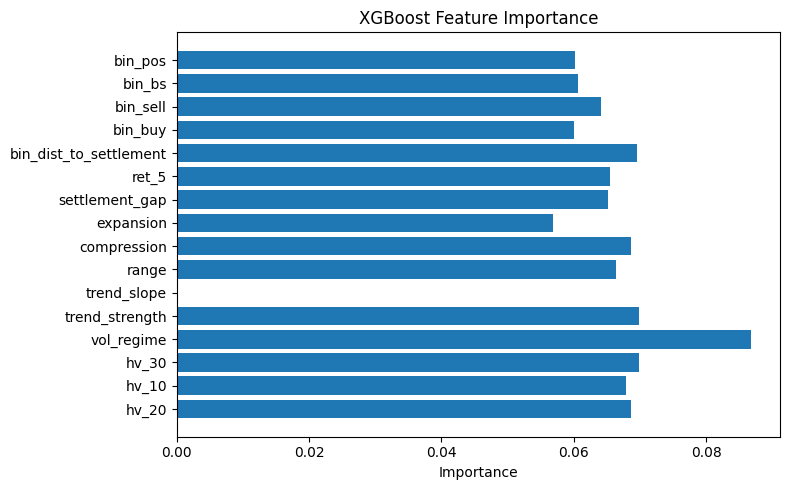

In [ ]:
import matplotlib.pyplot as plt

importances = best_xgb.feature_importances_

plt.figure(figsize=(8, 5))
plt.barh(extended_features, importances)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
test_slice = df_opt.iloc[int(len(df_opt)*0.8):].copy()
test_slice["pred_best"] = y_pred_best

# Go long when prediction = 1, hold for 1 bar
test_slice["strategy_ret_best"] = test_slice["return"] * test_slice["pred_best"]

num_trades = (test_slice["pred_best"] == 1).sum()
wins = (test_slice["strategy_ret_best"] > 0).sum()
win_rate = wins / num_trades * 100 if num_trades > 0 else 0
avg_ret = test_slice["strategy_ret_best"].mean() * 100

print("Trades:", num_trades)
print("Wins:", wins)
print(f"Win rate (tuned XGB): {win_rate:.2f}%")
print(f"Avg return per trade: {avg_ret:.4f}%")


Trades: 497
Wins: 225
Win rate (tuned XGB): 45.27%
Avg return per trade: -0.0107%


In [ ]:
# Predict on entire dataset (not just test)
df_opt["ml_signal"] = best_xgb.predict(df_opt[extended_features])


In [ ]:
SL_pct  = 0.005   # 0.5% stop loss
TP_pct  = 0.010   # 1% take profit


In [ ]:
import numpy as np

def run_backtest(df, signal_col="ml_signal", SL_pct=0.005, TP_pct=0.01):

    df = df.copy()
    df["Position"] = 0
    df["Trade_Return"] = 0.0
    df["Exit_Reason"] = ""

    in_trade = False
    entry_price = 0
    sl = 0
    tp = 0
    entry_index = None

    trades = []

    for i in range(1, len(df)):
        row = df.iloc[i]
        prev = df.iloc[i-1]

        # ============================
        # NEW ENTRY (ML = BUY)
        # ============================
        if not in_trade and prev[signal_col] == 1:
            in_trade = True
            entry_price = row["Close"]
            sl = entry_price * (1 - SL_pct)
            tp = entry_price * (1 + TP_pct)
            entry_index = i
            continue

        # ============================
        # EXIT CONDITIONS
        # ============================
        if in_trade:
            price = row["Close"]

            # SL Hit
            if price <= sl:
                ret = (sl - entry_price) / entry_price
                df.at[df.index[i], "Trade_Return"] = ret
                df.at[df.index[i], "Exit_Reason"] = "SL"
                trades.append(ret)
                in_trade = False
                continue

            # TP Hit
            if price >= tp:
                ret = (tp - entry_price) / entry_price
                df.at[df.index[i], "Trade_Return"] = ret
                df.at[df.index[i], "Exit_Reason"] = "TP"
                trades.append(ret)
                in_trade = False
                continue

            # Reverse signal
            if prev[signal_col] == 1 and row[signal_col] == 0:
                ret = (price - entry_price) / entry_price
                df.at[df.index[i], "Trade_Return"] = ret
                df.at[df.index[i], "Exit_Reason"] = "EXIT_SIGNAL"
                trades.append(ret)
                in_trade = False
                continue

    return df, trades


In [ ]:
bt_df, trades = run_backtest(df_opt, "ml_signal", SL_pct, TP_pct)

print("Number of Trades:", len(trades))


Number of Trades: 771


In [ ]:
wins = sum(1 for t in trades if t > 0)
losses = sum(1 for t in trades if t <= 0)
win_rate = wins / len(trades) * 100

print(f"Win Rate: {win_rate:.2f}%")
print(f"Avg Return per Trade: {np.mean(trades)*100:.2f}%")
print(f"Total Return: {np.sum(trades)*100:.2f}%")


Win Rate: 68.87%
Avg Return per Trade: 0.10%
Total Return: 74.97%


<Axes: title={'center': 'ML Strategy Equity Curve'}>

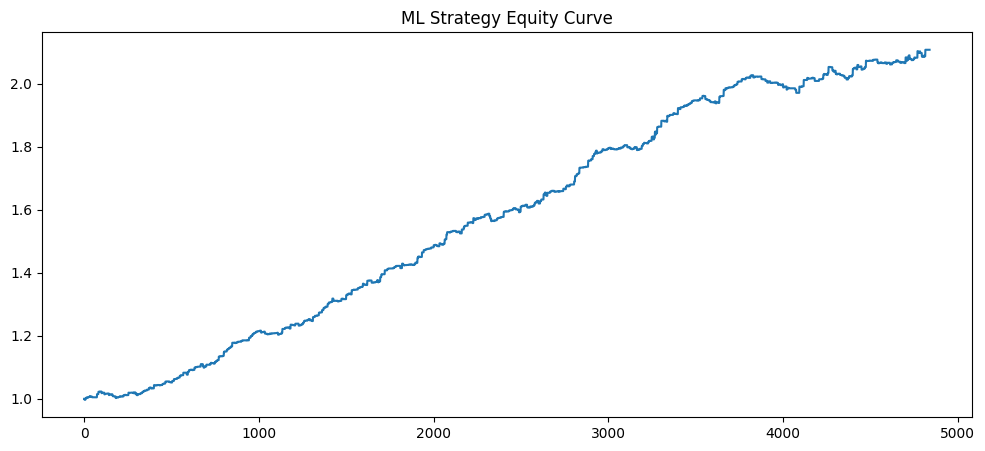

In [ ]:
bt_df["Equity"] = (1 + bt_df["Trade_Return"]).cumprod()

bt_df["Equity"].plot(figsize=(12,5), title="ML Strategy Equity Curve")


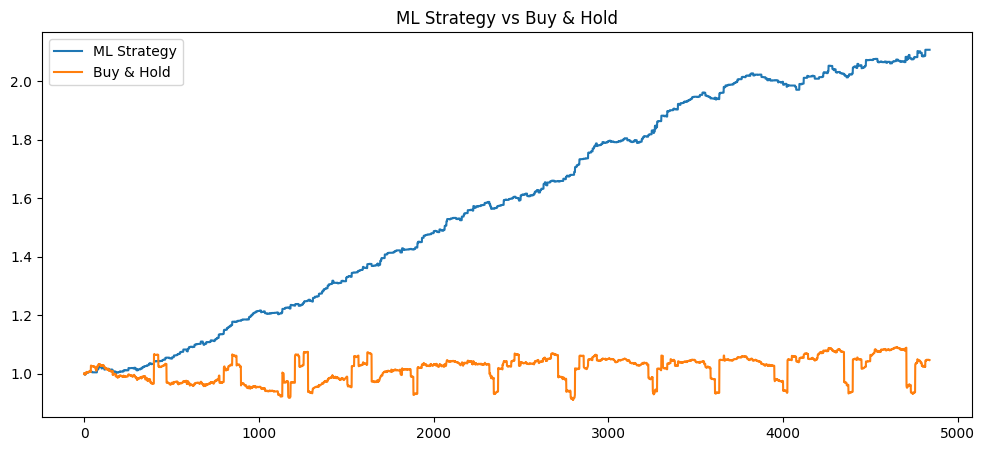

In [ ]:
buy_hold = df_opt["Close"] / df_opt["Close"].iloc[0]

plt.figure(figsize=(12,5))
plt.plot(bt_df["Equity"], label="ML Strategy")
plt.plot(buy_hold, label="Buy & Hold")
plt.legend()
plt.title("ML Strategy vs Buy & Hold")
plt.show()


In [ ]:
trade_log = bt_df[bt_df["Trade_Return"] != 0][["Datetime","Trade_Return","Exit_Reason"]]
trade_log.to_csv("Trade_Log.csv", index=False)
trade_log.head()


,Datetime,Trade_Return,Exit_Reason
3,2024-11-28 14:15:00,-0.002994,EXIT_SIGNAL
8,2024-11-29 09:15:00,0.004746,EXIT_SIGNAL
14,2024-11-29 10:45:00,0.002772,EXIT_SIGNAL
19,2024-11-29 12:00:00,-0.000489,EXIT_SIGNAL
25,2024-11-29 13:30:00,0.001657,EXIT_SIGNAL


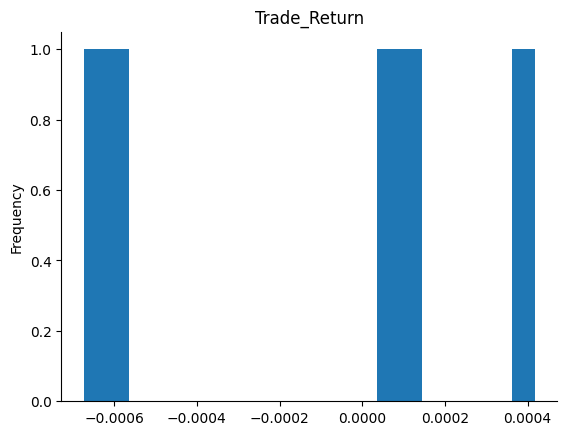

In [ ]:
from matplotlib import pyplot as plt
_df_0['Trade_Return'].plot(kind='hist', bins=20, title='Trade_Return')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Take the latest bar's features
X_last = df_opt[extended_features].iloc[[-1]]  # keep as DataFrame

# Model prediction: 1 = next bar up, 0 = next bar down
pred_label = best_xgb.predict(X_last)[0]

# Probability that next bar will go UP
proba_up = best_xgb.predict_proba(X_last)[0][1]
proba_dn = 1 - proba_up

print("Model says next move:", "UP (Bullish)" if pred_label == 1 else "DOWN (Bearish)")
print(f"Confidence UP: {proba_up*100:.2f}%")
print(f"Confidence DOWN: {proba_dn*100:.2f}%")


Model says next move: DOWN (Bearish)
Confidence UP: 7.54%
Confidence DOWN: 92.46%


In [ ]:
last = df_opt.iloc[-1]

bin_buy  = last["bin_buy"]
bin_sell = last["bin_sell"]
bin_pos  = last["bin_pos"]   # 1 = currently in long, -1 = in short, 0 = flat

print("Binocular state:")
print("  bin_buy :", bin_buy)
print("  bin_sell:", bin_sell)
print("  bin_pos :", bin_pos)

# Simple confluence logic
if pred_label == 1 and bin_buy == 1:
    print("\n👉 Strong BUY confluence (ML + Binocular agree UP)")
elif pred_label == 0 and bin_sell == 1:
    print("\n👉 Strong SELL confluence (ML + Binocular agree DOWN)")
else:
    print("\n⚠ No strong confluence – better to wait / reduce size")


Binocular state:
  bin_buy : 1
  bin_sell: 0
  bin_pos : 1

⚠ No strong confluence – better to wait / reduce size


In [ ]:
def get_signal(df, model, feature_cols, sl_pct=0.005, tp_pct=0.01,
               buy_threshold=0.55, sell_threshold=0.45):
    """
    df           : your feature dataframe (df_opt)
    model        : trained model (best_xgb)
    feature_cols : list of feature columns (extended_features)
    sl_pct       : stop-loss percentage (e.g. 0.005 = 0.5%)
    tp_pct       : take-profit percentage (e.g. 0.01 = 1%)
    buy_threshold: minimum prob_up to call it BUY
    sell_threshold: maximum prob_up to call it SELL

    Returns: dict with signal info
    """

    # Take latest row
    last_row = df.iloc[-1]
    X_last = last_row[feature_cols].to_frame().T

    # Explicitly ensure all feature columns are numeric
    # This addresses the ValueError: DataFrame.dtypes for data must be int, float, bool or category.
    for col in feature_cols:
        # pd.to_numeric will convert 'object' dtypes if possible,
        # and leave numeric dtypes as is. 'coerce' will turn non-convertible values into NaN.
        # Since we are dropping NaNs earlier, this should be safe.
        X_last[col] = pd.to_numeric(X_last[col], errors='coerce')

    # Model prediction & probability
    prob = model.predict_proba(X_last)[0]
    prob_down, prob_up = float(prob[0]), float(prob[1])
    pred_label = int(model.predict(X_last)[0])  # 1 = up, 0 = down

    # Map prediction + thresholds to human-readable signal
    if prob_up >= buy_threshold:
        ml_signal = "BUY"
    elif prob_up <= sell_threshold:
        ml_signal = "SELL"
    else:
        ml_signal = "NO TRADE"

    # Price & SL/TP suggestion
    last_close = float(last_row["Close"])
    if ml_signal == "BUY":
        sl_price = last_close * (1 - sl_pct)
        tp_price = last_close * (1 + tp_pct)
    elif ml_signal == "SELL":
        # For SELL view, SL is above, TP is below
        sl_price = last_close * (1 + sl_pct)
        tp_price = last_close * (1 - tp_pct)
    else:
        sl_price = None
        tp_price = None

    # Binocular context (if available)
    bin_buy  = last_row["bin_buy"]  if "bin_buy"  in df.columns else None
    bin_sell = last_row["bin_sell"] if "bin_sell" in df.columns else None
    bin_pos  = last_row["bin_pos"]  if "bin_pos"  in df.columns else None

    # Print a clean summary
    print("===== NEXT MOVE SNAPSHOT ====")
    print(f"Last time      : {last_row['Datetime']}")
    print(f"Last close     : {last_close:.2f}")
    print()
    print("Model view:")
    print(f"  → Prob UP    : {prob_up*100:.2f}%")
    print(f"  → Prob DOWN  : {prob_down*100:.2f}%")
    print(f"  → ML Signal  : {ml_signal}")
    print()

    if bin_buy is not None:
        print("Binocular state:")
        print(f"  bin_buy      : {bin_buy}")
        print(f"  bin_sell     : {bin_sell}")
        print(f"  bin_pos      : {bin_pos}")
        if ml_signal == "BUY" and bin_buy == 1:
            print("  ⚡ Confluence: STRONG BUY (ML + Binocular agree)")
        elif ml_signal == "SELL" and bin_sell == 1:
            print("  ⚡ Confluence: STRONG SELL (ML + Binocular agree)")
        else:
            print("  ℹ Confluence: Mixed / Weak, be conservative")
        print()

    if ml_signal in ["BUY", "SELL"]:
        print("Suggested risk levels:")
        print(f"  Stop Loss    : {sl_price:.2f}")
        print(f"  Take Profit  : {tp_price:.2f}")
    else:
        print("Suggested action: NO CLEAR EDGE → Wait / observe.")

    # Return data in case you want to log/use it programmatically
    return {
        "datetime": last_row["Datetime"],
        "last_close": last_close,
        "prob_up": prob_up,
        "prob_down": prob_down,
        "ml_signal": ml_signal,
        "sl_price": sl_price,
        "tp_price": tp_price,
        "bin_buy": bin_buy,
        "bin_sell": bin_sell,
        "bin_pos": bin_pos
    }

In [ ]:
signal_info = get_signal(
    df=df_opt,
    model=best_xgb,
    feature_cols=extended_features,
    sl_pct=0.005,   # 0.5% SL
    tp_pct=0.01,    # 1% TP
    buy_threshold=0.55,
    sell_threshold=0.45
)


===== NEXT MOVE SNAPSHOT ====
Last time      : 2025-12-09 15:15:00
Last close     : 25104.55

Model view:
  → Prob UP    : 7.54%
  → Prob DOWN  : 92.46%
  → ML Signal  : SELL

Binocular state:
  bin_buy      : 1
  bin_sell     : 0
  bin_pos      : 1
  ℹ Confluence: Mixed / Weak, be conservative

Suggested risk levels:
  Stop Loss    : 25230.07
  Take Profit  : 24853.50


In [ ]:
def get_signal_with_entry(df, model, feature_cols,
                          bfr_pct=0.02,  # entry buffer %
                          sl_pct=0.005,  # SL %
                          tp_pct=0.01,   # TP %
                          buy_threshold=0.55,
                          sell_threshold=0.45):

    last = df.iloc[-1]
    X_last = last[feature_cols].to_frame().T

    # Explicitly ensure all feature columns are numeric
    for col in feature_cols:
        X_last[col] = pd.to_numeric(X_last[col], errors='coerce')

    # ML prediction
    prob = model.predict_proba(X_last)[0]
    prob_down, prob_up = float(prob[0]), float(prob[1])

    if prob_up >= buy_threshold:
        ml_signal = "BUY"
    elif prob_up <= sell_threshold:
        ml_signal = "SELL"
    else:
        ml_signal = "NO TRADE"

    last_close = float(last["Close"])
    last_high  = float(last["High"])
    last_low   = float(last["Low"])

    # ENTRY PRICE (like your indicator)
    if ml_signal == "BUY":
        entry_price = last_high * (1 + bfr_pct/100)   # Buy Above High + buffer
        sl_price    = last_low * (1 - sl_pct)         # SL below Low
        tp_price    = entry_price * (1 + tp_pct)      # TP

    elif ml_signal == "SELL":
        entry_price = last_low * (1 - bfr_pct/100)    # Sell Below Low – buffer
        sl_price    = last_high * (1 + sl_pct)        # SL above High
        tp_price    = entry_price * (1 - tp_pct)      # TP

    else:
        entry_price = None
        sl_price = None
        tp_price = None

    # Binocular signals (if available)
    bin_buy  = last.get("bin_buy", None)
    bin_sell = last.get("bin_sell", None)
    bin_pos  = last.get("bin_pos", None)

    # Print summary
    print("========= NEXT MOVE ANALYSIS ======= corrooord")
    print("Last Candle:")
    print(f"  Time       : {last['Datetime']}")
    print(f"  Close      : {last_close:.2f}")
    print(f"  High       : {last_high:.2f}")
    print(f"  Low        : {last_low:.2f}")
    print()

    print("ML Prediction:")
    print(f"  Prob UP    : {prob_up*100:.2f}%")
    print(f"  Prob DOWN  : {prob_down*100:.2f}%")
    print(f"  ML Signal  : {ml_signal}")
    print()

    if ml_signal in ["BUY","SELL"]:
        print("Entry Setup:")
        print(f"  ➤ Entry Price : {entry_price:.2f}")
        print(f"  ➤ Stop Loss   : {sl_price:.2f}")
        print(f"  ➤ Take Profit : {tp_price:.2f}")
    else:
        print("Entry Setup: NO TRADE — low confidence")
    print()

    if bin_buy is not None:
        print("Binocular Confirmation:")
        print(f"  bin_buy  : {bin_buy}")
        print(f"  bin_sell : {bin_sell}")
        print(f"  bin_pos  : {bin_pos}")

        if ml_signal == "BUY" and bin_buy == 1:
            print("  ✔ STRONG BUY (ML + Binocular confluence)")
        elif ml_signal == "SELL" and bin_sell == 1:
            print("  ✔ STRONG SELL (ML + Binocular confluence)")
        else:
            print("  ⚠ Weak confluence")
    print()

    return {
        "signal": ml_signal,
        "entry": entry_price,
        "sl": sl_price,
        "tp": tp_price,
        "prob_up": prob_up,
        "prob_down": prob_down,
        "bin_buy": bin_buy,
        "bin_sell": bin_sell,
        "bin_pos": bin_pos
    }

In [ ]:
# ================================================
# 1) FIX ALL FEATURES → NUMERIC
# ================================================

# Start with all features from extended_features. It already contains all binocular features.
all_feature_cols = extended_features.copy()

# The following section is removed as it caused duplicate column names in all_feature_cols,
# because extended_features already includes the 'bin' columns.
# bin_cols = ["bin_dist_to_settlement", "bin_buy", "bin_sell", "bin_bs", "bin_pos"]
# for col in bin_cols:
#     if col in df_opt.columns:
#         all_feature_cols.append(col)

# Force numeric type
for col in all_feature_cols:
    df_opt[col] = pd.to_numeric(df_opt[col], errors="coerce")

# Drop rows with NaN in features
df_opt = df_opt.dropna(subset=all_feature_cols).reset_index(drop=True)

print("Final feature dtypes:")
print(df_opt[all_feature_cols].dtypes)


# ================================================
# 2) RE-SPLIT TRAIN/TEST
# ================================================

X = df_opt[all_feature_cols]
y = df_opt["target"]

train_size = int(len(df_opt) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


# ================================================
# 3) TRAIN MODEL (XGBoost)
# ================================================

from xgboost import XGBClassifier

best_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

best_xgb.fit(X_train, y_train)

print("Model Training Done!")


# ================================================
# 4) NEXT-MOVE SIGNAL ENGINE (WITH ENTRY / SL / TP)
# ================================================

def get_signal_with_entry(df, model, feature_cols,
                          bfr_pct=0.02,  # entry buffer %
                          sl_pct=0.005,  # 0.5% SL
                          tp_pct=0.01,   # 1% TP
                          buy_threshold=0.55,
                          sell_threshold=0.45):

    last = df.iloc[-1]
    X_last = last[feature_cols].to_frame().T

    # Explicitly ensure all feature columns are numeric
    for col in feature_cols:
        X_last[col] = pd.to_numeric(X_last[col], errors='coerce')

    # ML prediction
    prob = model.predict_proba(X_last)[0]
    prob_down, prob_up = float(prob[0]), float(prob[1])

    # Signal logic
    if prob_up >= buy_threshold:
        ml_signal = "BUY"
    elif prob_up <= sell_threshold:
        ml_signal = "SELL"
    else:
        ml_signal = "NO TRADE"

    last_close = float(last["Close"])
    last_high  = float(last["High"])
    last_low   = float(last["Low"])

    # Entry logic like your TradingView indicator
    if ml_signal == "BUY":
        entry_price = last_high * (1 + bfr_pct/100)
        sl_price    = last_low * (1 - sl_pct)
        tp_price    = entry_price * (1 + tp_pct)

    elif ml_signal == "SELL":
        entry_price = last_low * (1 - bfr_pct/100)
        sl_price    = last_high * (1 + sl_pct)
        tp_price    = entry_price * (1 - tp_pct)

    else:
        entry_price = None
        sl_price = None
        tp_price = None

    # Binocular signals
    bin_buy  = last.get("bin_buy", None)
    bin_sell = last.get("bin_sell", None)
    bin_pos  = last.get("bin_pos", None)

    print("\n========== NEXT MOVE REPORT ==========")
    print(f"Time          : {last['Datetime']}")
    print(f"Close         : {last_close:.2f}")
    print(f"High          : {last_high:.2f}")
    print(f"Low           : {last_low:.2f}\n")

    print("ML Prediction:")
    print(f"\u2192 Prob UP     : {prob_up*100:.2f}%")
    print(f"\u2192 Prob DOWN   : {prob_down*100:.2f}%")
    print(f"\u2192 ML Signal   : {ml_signal}\n")

    if ml_signal in ["BUY", "SELL"]:
        print("Entry Setup:")
        print(f"\u2192 Entry Price : {entry_price:.2f}")
        print(f"\u2192 Stop Loss   : {sl_price:.2f}")
        print(f"\u2192 Take Profit : {tp_price:.2f}\n")
    else:
        print("Entry Setup: NO TRADE\n")

    if bin_buy is not None:
        print("Binocular Confluence:")
        print(f"bin_buy       : {bin_buy}")
        print(f"bin_sell      : {bin_sell}")
        print(f"bin_pos       : {bin_pos}")

        if ml_signal == "BUY" and bin_buy == 1:
            print("\u2714 STRONG BUY (ML + Binocular)")
        elif ml_signal == "SELL" and bin_sell == 1:
            print("\u2714 STRONG SELL (ML + Binocular)")
        else:
            print("\u26a0 Weak / No confluence")

    return {
        "signal": ml_signal,
        "entry": entry_price,
        "sl": sl_price,
        "tp": tp_price,
        "prob_up": prob_up,
        "prob_down": prob_down,
        "bin_buy": bin_buy,
        "bin_sell": bin_sell,
        "bin_pos": bin_pos
    }


# ================================================
# 5) RUN NEXT MOVE SIGNAL
# ================================================

signal = get_signal_with_entry(
    df=df_opt,
    model=best_xgb,
    feature_cols=all_feature_cols
)

signal

Final feature dtypes:
hv_20                     float64
hv_10                     float64
hv_30                     float64
vol_regime                float64
trend_strength            float64
trend_slope               float64
range                     float64
compression                 int64
expansion                   int64
settlement_gap            float64
ret_5                     float64
bin_dist_to_settlement    float64
bin_buy                     int64
bin_sell                    int64
bin_bs                      int64
bin_pos                     int64
dtype: object
Model Training Done!

========== NEXT MOVE REPORT ==========
Time          : 2025-12-09 15:15:00
Close         : 25104.55
High          : 25120.10
Low           : 25102.40

ML Prediction:
→ Prob UP     : 19.10%
→ Prob DOWN   : 80.90%
→ ML Signal   : SELL

Entry Setup:
→ Entry Price : 25097.38
→ Stop Loss   : 25245.70
→ Take Profit : 24846.41

Binocular Confluence:
bin_buy       : 1
bin_sell      : 0
bin_pos       : 1

{'signal': 'SELL',
 'entry': 25097.379520000002,
 'sl': 25245.700499999995,
 'tp': 24846.405724800003,
 'prob_up': 0.19102606177330017,
 'prob_down': 0.8089739084243774,
 'bin_buy': np.int64(1),
 'bin_sell': np.int64(0),
 'bin_pos': np.int64(1)}